# Running a network

The purpose of this notebook is to showcase how to train, save, and re-load a network, as well as how to produce predictions once training is done.

For how to build a plant from scratch, feel free to look up the `1-build-plant.ipynb` notebook.
For how to build a network, feel free to look up the `2-build-net.ipynb` notebook.

Let's start by importing what we need.


In [16]:

import os
import sys
import json
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

colab_env = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
colab_initialized = True if os.path.exists("MotorNet") else False

if colab_env and not colab_initialized:
  !git clone https://github.com/OlivierCodol/MotorNet
  sys.path.append('MotorNet')
  print("Running cell using COLAB initialization...")
elif colab_env and colab_initialized:
  print("Already initialized using COLAB initialization.")
else:
  paths = [p for p in sys.path if os.path.exists(p)]
  local_initialized = True if [p for p in paths if "motornet" in os.listdir(p)] else False
  if local_initialized:
    %load_ext autoreload
    %autoreload 2
    print("Already initialized using LOCAL initialization.")
  else:
    path = [p for p in paths if p.__contains__("tutorials")]
    if len(path) != 1:
      raise ValueError("Path to MotorNet could not be determined with certainty.")
    sys.path.append(os.path.dirname(path[:path.rfind('tutorials')]))
    %load_ext autoreload
    %autoreload 2
    print("Running cell using LOCAL initialization...")


import motornet as mn

print('All packages imported.')
print('tensorflow version: ' + tf.__version__)
print('numpy version: ' + np.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Already initialized using LOCAL initialization.
All packages imported.
tensorflow version: 2.9.1
numpy version: 1.22.4



# I. Introduction

Since the purpose of this notebook is not to show how to build a plant, we will use a pre-built plant that comes with the `motornet` toolbox. This is a 4-muscles point mass plant, with `ReluMuscle` actuators.

We will also use the default `motornet` network, which is a GRU network. Since we only specify an integer (rather than a list of integers) for `n_units`, this will end up being a one-layer GRU network.

We will also recreate a network similar to that created in `2-build-net.ipynb`


In [17]:

def create_network():
  plant = mn.plants.ReluPointMass24()
  network = mn.nets.layers.GRUNetwork(plant=plant, n_units=50, kernel_regularizer=10**-6, name='network')
  task = mn.tasks.RandomTargetReachWithLoads(network=network, endpoint_load=3.)
  rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')

  input_dict = task.get_input_dict_layers()
  state0 = task.get_initial_state_layers()
  states_out = rnn(input_dict, initial_state=state0)

  nn = mn.nets.MotorNetModel(inputs=[input_dict, state0], outputs=states_out, name='model', task=task)
  nn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=task.losses, loss_weights=task.loss_weights)
  return nn

model = create_network()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 endpoint_load (InputLayer)     [(None, None, 2)]    0           []                               
                                                                                                  
 inputs (InputLayer)            [(None, None, 2)]    0           []                               
                                                                                                  
 joint0 (InputLayer)            [(None, 4)]          0           []                               
                                                                                                  
 cartesian0 (InputLayer)        [(None, 4)]          0           []                               
                                                                                              

# II. Training the network

The process for training a network is sensibly similar to that of `tensorflow`, from which `motornet` is built.


In [18]:

n_t = 100
n_batches = 30
batch_size = 32

# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger()]

[inputs, targets, init_states] = model.task.generate(n_timesteps=n_t, batch_size=n_batches * batch_size)
h = model.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)




30/30 [==============================] - 9s 125ms/step - loss: 0.6802 - position_loss: 0.6442 - gru_regularizer_loss: 0.3565 - l2_xdx_activation_loss: 6.0376e-05



Using the training log, stored in the `BatchLogger` callback object, we can plot all losses over training iterations.


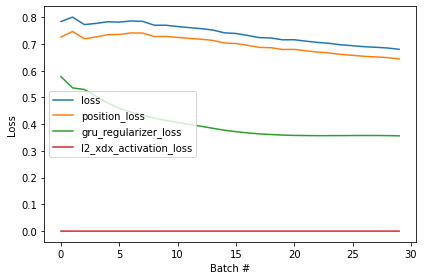

In [19]:

def print_training_log(log):
  plt.figure().set_tight_layout(True)
  for kk, vv in log.items():
    plt.plot(vv, label=kk)

  plt.ylabel("Loss")
  plt.xlabel("Batch #")
  plt.legend()
  plt.show()

training_log = callbacks[0].history
print_training_log(log=training_log)


# III. Evaluating performance

Again, this is fairly similar to what one would expect from a `tensorflow` model.
A forward pass on the model (with `training=False`) will yield a dictionary containing all the states over time.


In [20]:
[inputs, targets, init_states] = model.task.generate(n_timesteps=n_t, batch_size=32)
results = model([inputs, init_states], training=False)

print("returned shape of each state:")
print("-----------------------------")
for k, v in results.items():
  print(k + ": ", v.shape)


returned shape of each state:
-----------------------------
joint position:  (32, 100, 4)
cartesian position:  (32, 100, 4)
muscle state:  (32, 100, 4, 4)
geometry state:  (32, 100, 4, 4)
proprioceptive feedback:  (32, 100, 8, 1)
visual feedback:  (32, 100, 2, 1)
excitation:  (32, 100, 4)
gru_hidden_0:  (32, 100, 50)


We can plot these states to quickly visualize what the network is doing.


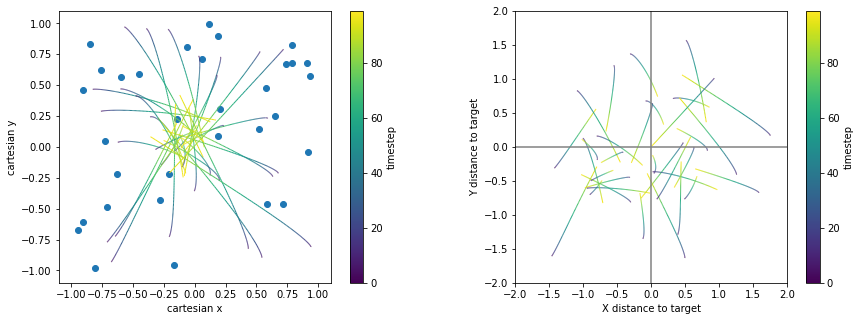

In [21]:

plotor = mn.utils.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(15,5))

  plt.subplot(1,2,1)
  plt.ylim([-1.1, 1.1])
  plt.xlim([-1.1, 1.1])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()

plot_simulations(xy=results["cartesian position"], target_xy=targets)


# IV. Saving the model

Next, we can save the model using built-in methods. We will also save the training history as a `.json` file.


In [22]:

weight_file = "save" + os.path.sep + "weights.h5"
log_file = "save" + os.path.sep + "log.json"
data_file = "save" + os.path.sep + "data.pickle"
cfg_file = "save" + os.path.sep + "cfg"

# save model weights
model.save_weights(weight_file, save_format='h5')

# save model configuration
if not os.path.isfile(cfg_file + ".json"):
  model.save_model(cfg_file)

# save training history (log)
with open(log_file, 'w') as file:
    json.dump(training_log, file)

print("Done.")

Done.



# V. Loading the model

## V. 1. The configuration file
This file is what the `model.save_model` method produces. It contains a dictionary with all the parameter and configuration values used to create the model. Let's look into its structure quickly.


In [23]:


with open(cfg_file + ".json", 'r') as file:
    cfg = json.load(file)


for k1, v1 in cfg.items():
  print(k1 + ":")
  for k2, v2 in v1.items():
    if type(v2) is dict:
      print("\t\t" + k2 + ":")
      for k3, v3 in v2.items():
        print("\t\t\t\t" + k3 + ": ", v3)
    else:
      print("\t\t" + k2 + ": ", v2)


Task:
		name:  RandomTargetReachWithLoads
		delay_range:  [0, 0]
		do_recompute_targets:  False
		dt:  0.01
		endpoint_load:  3.0
		initial_joint_state:  None
		initial_joint_state_original:  None
		n_initial_joint_states:  None
		training_batch_size:  32
		training_n_timesteps:  100
		losses:  [{'assigned output': 'cartesian position', 'loss object': '<motornet.nets.losses.PositionLoss object at 0x000002D36EB3CA90>', 'loss name': 'position', 'loss weight': 1.0, 'compounded': False}, {'assigned output': 'muscle state', 'loss object': '<motornet.nets.losses.L2xDxActivationLoss object at 0x000002D36EB3CA00>', 'loss name': 'l2_xdx_activation', 'loss weight': 5, 'compounded': False}, {'assigned output': 'gru_hidden_0', 'loss object': '<motornet.nets.losses.L2xDxRegularizer object at 0x000002D36EB3C9A0>', 'loss name': 'gru_regularizer', 'loss weight': 0.1, 'compounded': False}]
Network:
		hidden_noise_sd:  0.0
		kernel_regularizer_weight:  1e-06
		recurrent_regularizer_weight:  0.0
		n_unit


## V. 2. Training history

We can use the `.json` file containing the training history to retrieve and plot losses over time.

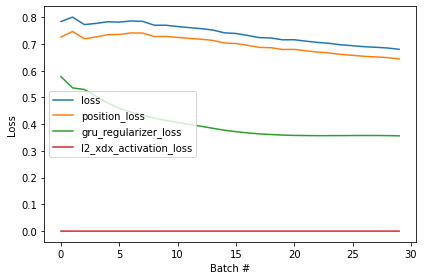

In [24]:

# retrieve and plot training history
with open(log_file, 'r') as file:
    loaded_training_log = json.load(file)

print_training_log(log=loaded_training_log)




## V. 3. The model itself

Unfortunately there is no straightforward, one-liner way to save a model. This is to an extent due to limitations from the `tensorflow` saving routines, and also due to the fact that we use fairly non-conventional models, with plants, tasks, etc... nested into one object. Usually, reloading the model would involve re-creating the same model, and applying the trained weights to that model again. To re-create the model, one could re-use the same function as was used to create the original model (that's what we will do here), or one could exploit the configuration file we saved and re-loaded above to recreate a model exhaustively. The latter method might be more tedious to implement but has the benefit of being more exhaustive on the long run.

Note that the task object is contained in the network and so can be retried from there.


In [25]:

# The model has to be re-created
model2 = create_network()
task2 = model2.task

# We then load the weights obtained from the training process
model2.load_weights(weight_file)




# VI. Evaluating the loaded model

We can then do a forward pass the loaded model like we did on the original model.

We can also save the data resulting from the forward pass, for later analyses if desired. This could have been done following the evaluation of the original model as well, obviously.


In [26]:
[inputs, targets, init_states] = task2.generate(n_timesteps=n_t, batch_size=32)

results = model2([inputs, init_states], training=False)

# convert results to numpy array for saving later.
# (this is not mandatory)
inputs_np = {key: np.array(val) for key, val in inputs.items()}
results_np = {key: np.array(val) for key, val in results.items()}

# save as a .pickle file
with open(data_file, 'wb') as file:
  pickle.dump(
    obj={'results': results_np,
         'inputs': inputs_np,
         'targets': np.array(targets),
         'weights': model.get_weights(),
         'training_log': training_log,
         'task': cfg['Task'],
         'controller': cfg['Network'],
         'plant': cfg['Plant']},
    file=file)
  file.close()

print("Done.")


Done.


# VII. Analyzing saved data

We can reload the saved data to perform analyses on it at any later time.

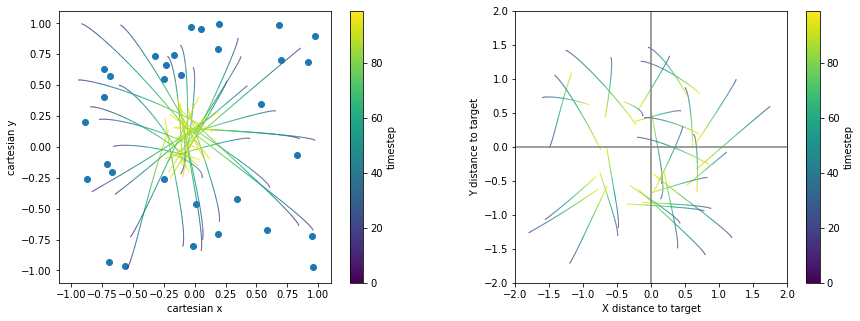

In [27]:


# open data file
with open(data_file, 'rb') as file:
  data = pickle.load(file)

# plot data from data file
plot_simulations(xy=data["results"]["cartesian position"], target_xy=data["targets"])
